In [4]:
import torch
from torch import nn
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import math
from dataloading import DataParser
from easydict import EasyDict

from indicators import ZigZagNew
from backtest import MovingWindow

In [382]:
class SimpleModel(nn.Module):
    def __init__(self, feature_size, nh):
        self.nh = nh
        self.feature_size = feature_size
        self.inp_size = self.feature_size + 2        
        super(SimpleModel, self).__init__()

        self.fc_features_in = nn.Linear(self.feature_size, nh)
        self.fc_last_state_in = nn.Linear(2, nh)
        self.fc_hid = nn.Linear(nh, nh)
        self.fc_out = nn.Linear(nh, 1)

        self.batch_norm_hid = nn.BatchNorm1d(nh)
        self.batch_norm_out = nn.BatchNorm1d(1)        
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    # def forward(self, x):
    #     features, last_pred, last_res = x[:, :-1], x[:, -2:-1], x[:, -1:]
    #     last_state_pred = self.tanh(self.tanh(last_res*10)*last_pred*10)
    #     return last_state_pred
    
    def forward(self, x):
        features, last_state = x[:, :-2], x[:, -2:]

        # last_state = self.relu(self.fc_last_state_in(self.last_state))
        # last_state = self.relu(self.fc_hid(last_state))
        # last_state = self.fc_out(last_state)

        features = self.relu(self.fc_features_in(features))
        features = self.relu(self.fc_hid(features))
        # features = self.relu(self.fc_hid(features))
        # features = self.relu(self.fc_hid(features))
        features = self.fc_out(features)
        
        output = self.tanh(features)
        return output

In [383]:
model = SimpleModel(5, 5)
print(model.inp_size)
model.eval()
model(torch.ones((1, model.inp_size)))

7


tensor([[-0.3256]], grad_fn=<TanhBackward0>)

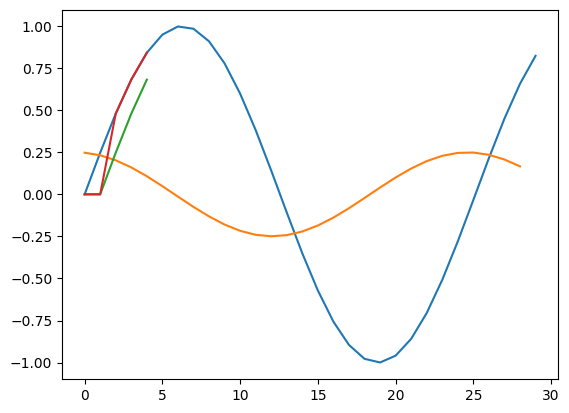

In [408]:
p = np.array([math.sin(x/4) for x in range(30)])# + (np.random.random(L)-0.5)*2
dp = p[1:] - p[:-1]
L = len(p)
plt.plot(p)
plt.plot(dp)

fsize = 2
features = []
for i in range(p.shape[0]):
    if i < fsize:
        features.append(np.zeros(fsize))
    else:
        features.append(p[i-1:i+1])

features = torch.from_numpy(np.array(features).astype(np.float32))
plt.plot(features[:5]);

In [42]:
cfg = EasyDict({"data_type": "metatrader", "period": "M15", "ticker": "SBRF"})
data_pd, data_np = DataParser(cfg).load()

In [323]:
wsize = 256
fsize = 1
zz = ZigZagNew(10)
mw = MovingWindow(data_np, wsize)
last_type = 0
p, features = [], []
# for t in range(wsize*5-1, data_np.Close.shape[0]):
for t in range(500, data_np.Close.shape[0]):
    hist_window = mw(t)[0]
    zzx, zzp, zzt = zz.update(hist_window)
    zzx -= zzx[0]
    zzp -= zzp[-1]
    zzx = 127 - zzx
    if zzt[-1] != last_type:
        last_type = zzt[-1]
        # plt.plot(zzx, zzp)
        # plt.plot(hist_window.Low - hist_window.Low[-1])
        # plt.plot(hist_window.High - hist_window.High[-1])
        
        p.append(hist_window.Close[-1])
        # features.append(np.vstack([zzx[:fsize], zzp[:fsize], zzt[:fsize]]))
        features.append(p[-1])
        if len(p) >= 30:
            break
        
features = torch.from_numpy(np.expand_dims(np.array(features).astype(np.float32), 1))
p = torch.from_numpy(np.array(p + p[:1]).astype(np.float32))
dp = p[1:] - p[:-1]
print(features.shape, dp.shape)

torch.Size([30, 1]) torch.Size([30])


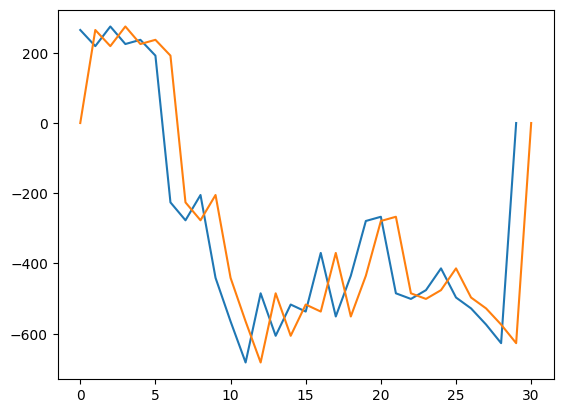

In [324]:
plt.plot(dp.cumsum(0))
plt.plot(p - p[0])

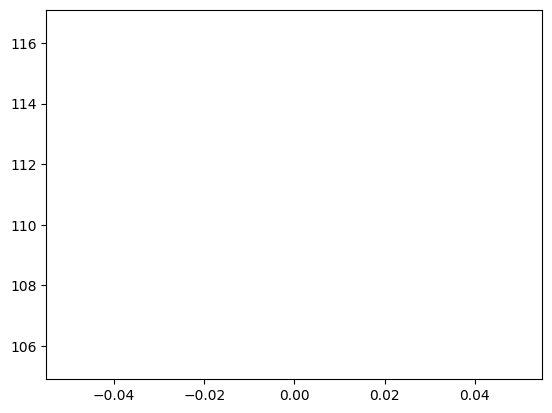

In [261]:
plt.plot(127-features[14, 0], features[14, 1])

In [263]:
features = features.reshape((-1, fsize*3))

RuntimeError: shape '[-1, 30]' is invalid for input of size 29

In [409]:
model = SimpleModel(features.shape[1], 10)
model.eval()
summary(model, (model.inp_size,), device="cpu")

# model.fc2.weight = nn.Parameter(torch.tensor([[10.]]))
# for param in model.fc2.parameters():
#     param.requires_grad = False

# print(model.fc2.weight)
# print(model.fc2.bias)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
              Tanh-6                    [-1, 1]               0
Total params: 151
Trainable params: 151
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [400]:
model.inp_size

3

In [421]:
num_epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def autoregress_sequense(dp, features, epoch=0, output_sequense=False):
    outputs, pred_results = torch.zeros(dp.shape[0]), torch.zeros(dp.shape[0])
    loss, output, pred_result = 0, torch.zeros((1, 1)), torch.zeros((1, 1))
    for i in range(dp.shape[0]):
        input = torch.hstack([features[i:i+1], output, pred_result])
        output = model(input)
        pred_result = dp[i] * output

        if output_sequense:
            outputs[i] = output
            pred_results[i] = pred_result
        else:
            loss -= pred_result
            print(f"{epoch + 1:03} {i + 1:04}: {loss.item():6.3f} -= {output.item():6.3f} * {dp[i]:6.3f} = {pred_result.item():6.3f}")            
    if output_sequense:
        return outputs.detach().numpy(), pred_results.detach().numpy()
    else:
        return loss, output
        
# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss, _ = autoregress_sequense(dp, features, epoch)
    loss.backward()
    optimizer.step()
    print("---------------------------")

001 0001: -0.234 -=  0.947 *  0.247 =  0.234
001 0002: -0.454 -=  0.947 *  0.232 =  0.220
001 0003: -0.656 -=  1.000 *  0.202 =  0.202
001 0004: -0.816 -=  0.998 *  0.160 =  0.160
001 0005: -0.921 -=  0.981 *  0.108 =  0.105
001 0006: -0.958 -=  0.748 *  0.049 =  0.036
001 0007: -0.962 -= -0.328 * -0.014 =  0.004
001 0008: -1.030 -= -0.909 * -0.075 =  0.068
001 0009: -1.160 -= -0.987 * -0.131 =  0.129
001 0010: -1.338 -= -0.996 * -0.180 =  0.179
001 0011: -1.555 -= -0.998 * -0.217 =  0.216
001 0012: -1.795 -= -0.997 * -0.241 =  0.240
001 0013: -2.043 -= -0.996 * -0.249 =  0.248
001 0014: -2.283 -= -0.989 * -0.243 =  0.240
001 0015: -2.495 -= -0.963 * -0.221 =  0.213
001 0016: -2.671 -= -0.947 * -0.185 =  0.175
001 0017: -2.796 -= -0.908 * -0.138 =  0.126
001 0018: -2.860 -= -0.775 * -0.083 =  0.064
001 0019: -2.868 -= -0.359 * -0.022 =  0.008
001 0020: -2.884 -=  0.392 *  0.040 =  0.016
001 0021: -2.970 -=  0.858 *  0.100 =  0.086
001 0022: -3.119 -=  0.975 *  0.153 =  0.150
001 0023: 

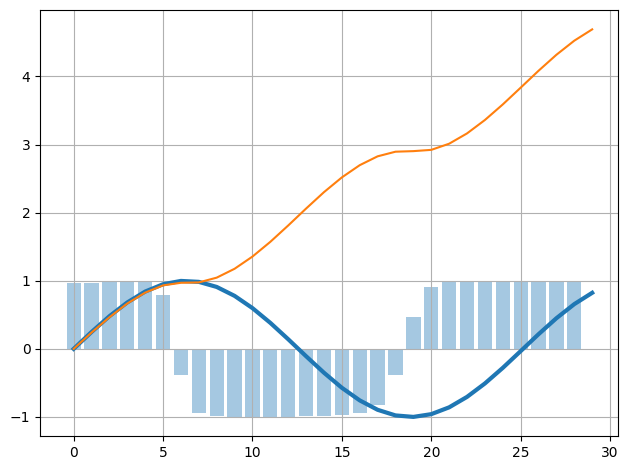

In [422]:
pred_deals, pred_res = torch.zeros(dp.shape[0]), torch.zeros(dp.shape[0])
pred_deal_last, pred_res_last = 1*torch.zeros((1, 1)), -torch.zeros((1, 1))
# pred_deal_last, pred_res_last = -1*torch.ones((1, 1)), torch.ones((1, 1))

pred_deals, pred_res = autoregress_sequense(dp, features, output_sequense=True)
# print(pred_deals)    
# print(pred_res)

plt.plot(p - p[0], linewidth=3)
plt.bar(list(range(len(pred_deals))), height=pred_deals, alpha=0.4)
plt.plot(np.hstack([np.zeros(1), pred_res.cumsum(0)]))
plt.grid("on")
plt.tight_layout()
plt.grid("on")

In [239]:
pred_deals.var()

0.0

In [180]:
loss, _ = autoregress_sequense(dp, features, epoch)

010 0001: 134.000 -= -1.000 * 134.000 = -134.000
010 0002: 190.000 -= -1.000 * 56.000 = -56.000
010 0003: 140.000 -= -1.000 * -50.000 = 50.000
010 0004: 152.000 -= -1.000 * 12.000 = -12.000
010 0005: 107.000 -= -1.000 * -45.000 = 45.000
010 0006: -311.000 -= -1.000 * -418.000 = 418.000
010 0007: -362.000 -= -1.000 * -51.000 = 51.000
010 0008: -290.000 -= -1.000 * 72.000 = -72.000
010 0009: -526.000 -= -1.000 * -236.000 = 236.000
010 0010: -650.000 -= -1.000 * -124.000 = 124.000
010 0011: -767.000 -= -1.000 * -117.000 = 117.000
010 0012: -570.000 -= -1.000 * 197.000 = -197.000
010 0013: -691.000 -= -1.000 * -121.000 = 121.000
010 0014: -602.000 -= -1.000 * 89.000 = -89.000
010 0015: -622.000 -= -1.000 * -20.000 = 20.000
010 0016: -455.000 -= -1.000 * 167.000 = -167.000
010 0017: -636.000 -= -1.000 * -181.000 = 181.000
010 0018: -520.000 -= -1.000 * 116.000 = -116.000
010 0019: -364.000 -= -1.000 * 156.000 = -156.000
010 0020: -352.000 -= -1.000 * 12.000 = -12.000
010 0021: -570.000 -= -